In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import os
import re
import json
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from pprint import pprint
from IPython.display import Audio
from scipy.io import wavfile

from bark.bark import SAMPLE_RATE, generate_audio, preload_models

In [2]:
def save_history(basepath: str, audio_array: np.ndarray, prompt: str, generation_data: list):
  np.savez(f"{basepath}.npz", semantic_prompt=generation_data[0], coarse_prompt=generation_data[1], fine_prompt=generation_data[2])
  with open(f"{basepath}.txt", "w", encoding="utf-8") as fp: fp.write(prompt)
  wavfile.write(f"{basepath}.wav", SAMPLE_RATE, audio_array)

def load_history(filepath: str):
  return np.load(filepath)

def load_voice(filepath: str):
  sample_rate, audio_array = wavfile.read(filepath)
  return audio_array

In [3]:
NUM_EPOCHS = 1
NUM_STEPS = 10000

BATCH_SIZE = 4

DURATION = 3000

EMBEDDING_DIM = int(DURATION * SAMPLE_RATE / 1000)

In [4]:
class VoiceDataset(Dataset):
  def __init__(self, directory, embedding_dim = EMBEDDING_DIM):
    super().__init__()
    self.k = 1
    self.population = 0
    self.length = 0
    self.embedding_dim = embedding_dim
    self.voices = []
    self.base_map = {}
    for filename in os.listdir(directory):
      if not filename.endswith(".wav"): continue
      self.voices.append([])
      self.population += 1
      folder_name = filename.split(".wav")[0]
      self.base_map[folder_name] = self.population
      for fn in os.listdir(f"./data/bark3/{folder_name}"):
        if not fn.endswith(".wav"): continue
        self.voices[-1].append(load_voice(f"./data/bark3/{folder_name}/{fn}"))
        self.length += 1

  def __getitem__(self, _):
    samples, targets, labels = [], [], torch.zeros(len(self.voices))
    r_index = random.randint(0, len(self.voices) - 1)
    labels[r_index] = 1
    for person in self.voices:
      for s in random.choices(person, k=self.k):
        r = random.randint(0, len(s) - self.embedding_dim)
        samples.append(s[r:r + self.embedding_dim])
      for t in random.choices(self.voices[r_index], k=self.k):
        r = random.randint(0, len(t) - self.embedding_dim)
        targets.append(t[r:r + self.embedding_dim])
    samples = torch.tensor(np.concatenate(samples)).view(len(self.voices) * self.k, -1).float()
    targets = torch.tensor(np.concatenate(targets)).view(len(self.voices) * self.k, -1).float()
    return samples, targets, labels

  def get_selected(self, target):
    samples, targets = [], []
    for person in self.voices:
      for s in random.choices(person, k=self.k):
        r = random.randint(0, len(s) - self.embedding_dim)
        samples.append(s[r:r + self.embedding_dim])
        r = random.randint(0, len(target) - self.embedding_dim)
        targets.append(target[r:r + self.embedding_dim])
    samples = torch.tensor(np.concatenate(samples)).view(len(self.voices) * self.k, -1).float()
    targets = torch.tensor(np.concatenate(targets)).view(len(self.voices) * self.k, -1).float()
    return samples, targets

  def __len__(self): return self.length

In [5]:
dataset = VoiceDataset("./data/bark3")
torch.save(dataset, "./checkpoints/bark_dataset.pt")

C:\Users\User\AppData\Local\Temp\ipykernel_9800\2903563552.py:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_array = wavfile.read(filepath)


In [6]:
dataset = torch.load("./checkpoints/bark_dataset.pt")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)

In [7]:
class Judge(nn.Module):
  def __init__(self, k):
    super().__init__()
    self.k = k
    self.seq1 = nn.Sequential(
      nn.Conv1d(1, 64, int(0.025 * SAMPLE_RATE), int(0.01 * SAMPLE_RATE)),
      nn.BatchNorm1d(64),
      nn.MaxPool1d(4),
      nn.ReLU(True),
      nn.Conv1d(64, 128, 4),
      nn.BatchNorm1d(128),
      nn.MaxPool1d(2),
      nn.ReLU(True),
      nn.Conv1d(128, 256, 4),
      nn.BatchNorm1d(256),
      nn.MaxPool1d(2),
      nn.ReLU(True)
    )
    self.lstm = nn.LSTM(256, 256, 1, batch_first=True, bidirectional=True)
    self.seq2 = nn.Sequential(
      nn.ReLU(),
      nn.Flatten(),
      nn.Dropout(0.3)
    )
    self.seq3 = nn.Sequential(
      nn.Linear(256 * 64, 1024),
      nn.ReLU(True),
      nn.Dropout(0.2),
      nn.Linear(1024, 256),
      nn.ReLU(True),
      nn.Dropout(0.1),
      nn.Linear(256, 64),
      nn.ReLU(True),
      nn.Linear(64, 1),
      nn.Sigmoid(),
    )

  def forward(self, sample, target):
    outputs1 = self.seq1(sample.view(-1, 1, sample.size(1)))
    outputs2 = self.seq1(target.view(-1, 1, target.size(1)))
    outputs1, _ = self.lstm(outputs1.permute(0, 2, 1))
    outputs2, _ = self.lstm(outputs2.permute(0, 2, 1))
    outputs1 = self.seq2(outputs1)
    outputs2 = self.seq2(outputs2)
    outputs = self.seq3(torch.cat((outputs1, outputs2), dim=1))
    outputs = torch.cat([outputs[self.k * i:self.k * (i + 1), :] for i in range(0, outputs.size(0), self.k)], dim=1).sum(0)
    return outputs

class Model(nn.Module):
  def __init__(self, k = 1):
    super().__init__()
    self.k = k
    self.judge = Judge(self.k)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, samples, targets):
    outputs = []
    for s, t in zip(samples, targets): outputs.append(self.judge(s, t).unsqueeze(1))
    outputs = torch.cat(tuple(outputs), dim=1).permute(1, 0)
    outputs = self.softmax(outputs)
    return outputs

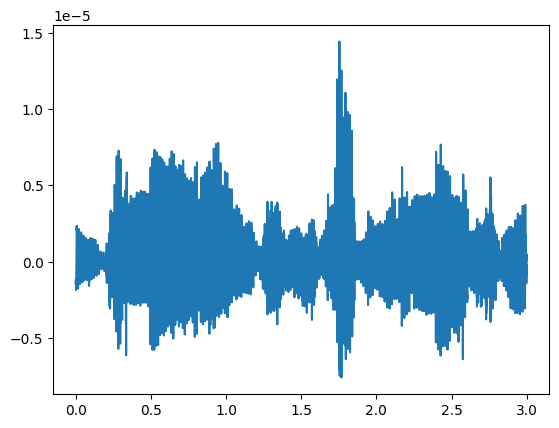

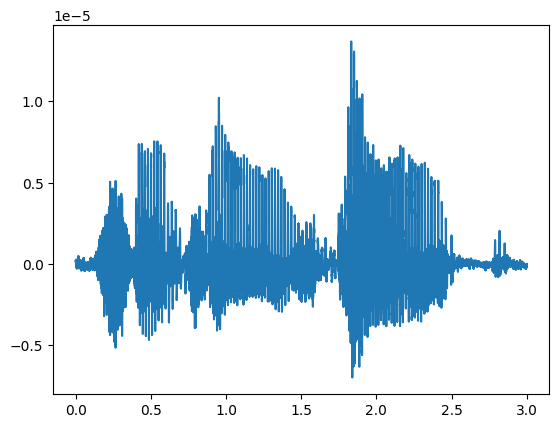

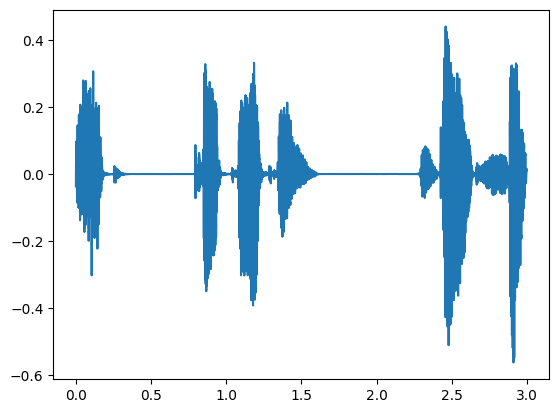

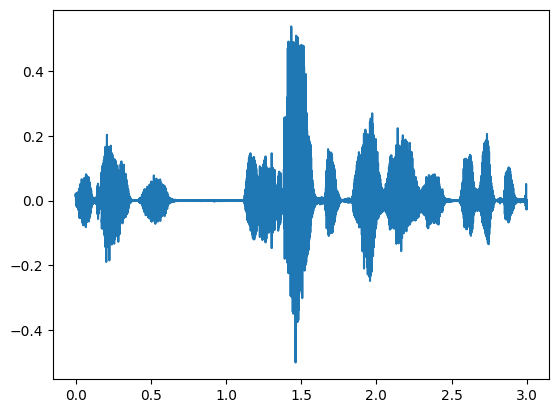

tensor([0.5140, 0.5129, 0.5160, 0.5142, 0.5129, 0.5133],
       grad_fn=<SumBackward1>)
tensor([0.5151, 0.5149, 0.5151, 0.5145, 0.5147, 0.5134],
       grad_fn=<SumBackward1>)


In [8]:
samples, targets, labels = next(iter(dataloader))
model = Judge(dataset.k)
plt.plot(np.arange(0, 3, 1 / SAMPLE_RATE), samples[0][0].numpy())
plt.show()
plt.plot(np.arange(0, 3, 1 / SAMPLE_RATE), samples[0][1].numpy())
plt.show()
plt.plot(np.arange(0, 3, 1 / SAMPLE_RATE), samples[0][2].numpy())
plt.show()
plt.plot(np.arange(0, 3, 1 / SAMPLE_RATE), targets[0][0].numpy())
plt.show()
print(model(samples[0], targets[0]))
print(model(samples[1], targets[1]))

In [9]:
samples, targets, labels = next(iter(dataloader))
model = Model(dataset.k)
loss_fn = nn.CrossEntropyLoss()
outputs = model(samples, targets)
print(samples.shape, targets.shape)
print(outputs)
print(labels)
print(loss_fn(outputs, labels))

torch.Size([4, 6, 72000]) torch.Size([4, 6, 72000])
tensor([[0.1669, 0.1666, 0.1669, 0.1665, 0.1667, 0.1665],
        [0.1665, 0.1670, 0.1664, 0.1667, 0.1668, 0.1665],
        [0.1667, 0.1667, 0.1668, 0.1666, 0.1665, 0.1667],
        [0.1666, 0.1668, 0.1666, 0.1670, 0.1666, 0.1664]],
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]])
tensor(1.7918, grad_fn=<DivBackward1>)


In [10]:
for _ in tqdm(range(100)): samples, targets, labels = next(iter(dataloader))

  0%|          | 0/100 [00:00<?, ?it/s]

100/10000:	1.7917
200/10000:	1.7918
300/10000:	1.7917
400/10000:	1.7918
500/10000:	1.7918
600/10000:	1.7917
700/10000:	1.7916
800/10000:	1.7911
900/10000:	1.7774
1000/10000:	1.7327
1100/10000:	1.7269
1200/10000:	1.7301
1300/10000:	1.7231
1400/10000:	1.7233
1500/10000:	1.7259
1600/10000:	1.7196
1700/10000:	1.7312
1800/10000:	1.7232
1900/10000:	1.7266
2000/10000:	1.7236
2100/10000:	1.7232
2200/10000:	1.7228
2300/10000:	1.7281
2400/10000:	1.7236
2500/10000:	1.7230
2600/10000:	1.7247
2700/10000:	1.7265
2800/10000:	1.7272
2900/10000:	1.7261
3000/10000:	1.7264
3100/10000:	1.7246
3200/10000:	1.7260
3300/10000:	1.7270
3400/10000:	1.7237
3500/10000:	1.7244
3600/10000:	1.7281
3700/10000:	1.7243
3800/10000:	1.7261
3900/10000:	1.7271
4000/10000:	1.7259
4100/10000:	1.7243
4200/10000:	1.7278
4300/10000:	1.7246
4400/10000:	1.7251
4500/10000:	1.7239
4600/10000:	1.7237
4700/10000:	1.7265
4800/10000:	1.7219
4900/10000:	1.7263
5000/10000:	1.7233
5100/10000:	1.7256
5200/10000:	1.7260
5300/10000:	1.7240
54

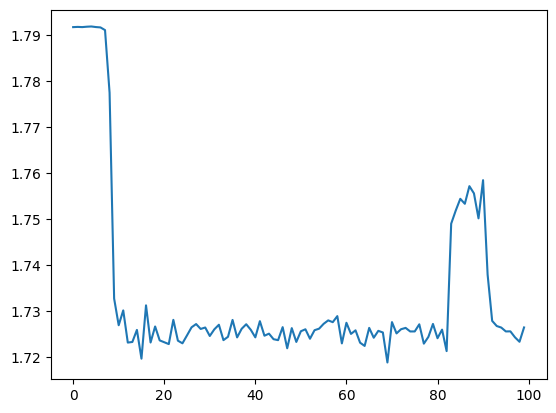

In [11]:
torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Model(dataset.k)
optimizer = optim.Adam(model.parameters(), lr=3e-5, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()
losses = []
display_losses = []

model.train()

if device == "cuda": model.cuda()
for step in range(1, NUM_STEPS + 1):
  optimizer.zero_grad()
  samples, targets, labels = next(iter(dataloader))
  outputs = model(samples.to(device), targets.to(device))
  loss = loss_fn(outputs.to(device), labels.to(device))
  losses.append(loss.item())
  loss.backward()
  optimizer.step()
  if step % 100 == 0:
    display_losses.append(np.mean(losses))
    print(f"{step}/{NUM_STEPS}:\t{display_losses[-1]:.4f}")
    losses = []
print("Training Ended!")
plt.plot(display_losses)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\User\AppData\Local\Temp\ipykernel_9800\2903563552.py:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_array = wavfile.read(filepath)


array([[0.28458865, 0.28458245, 0.1048753 , 0.10668699, 0.11454406,
        0.10472255]])

array([496., 483.,   0.,   4.,  17.,   0.])

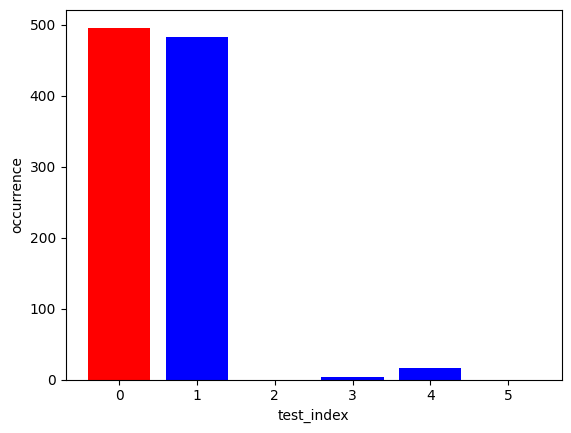

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.28533308, 0.28533497, 0.10513903, 0.10729444, 0.11191772,
        0.10498075]])

array([483., 493.,   0.,   8.,  16.,   0.])

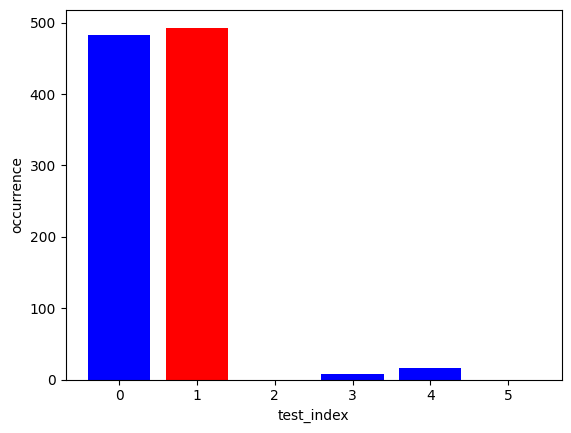

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.07851264, 0.07851249, 0.21306818, 0.21001741, 0.20662059,
        0.21326868]])

array([  0.,   0., 282., 390., 142., 186.])

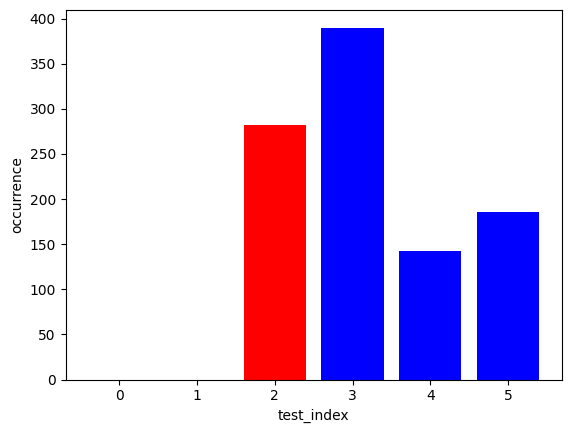

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.07837963, 0.0783796 , 0.21276953, 0.20980348, 0.20769784,
        0.21296992]])

array([  0.,   0., 289., 347., 184., 180.])

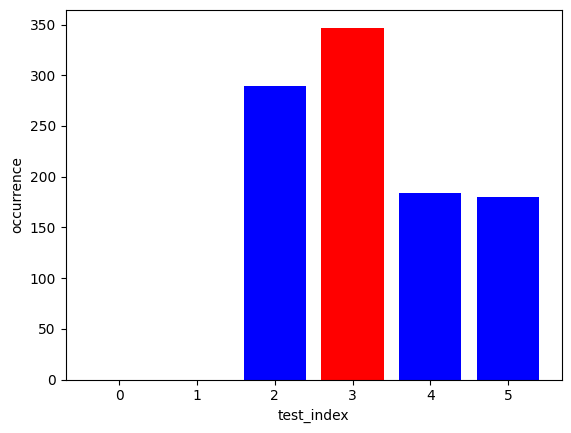

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.07839186, 0.07839627, 0.21306898, 0.21137206, 0.20613566,
        0.21263516]])

array([  0.,   0., 289., 331., 177., 203.])

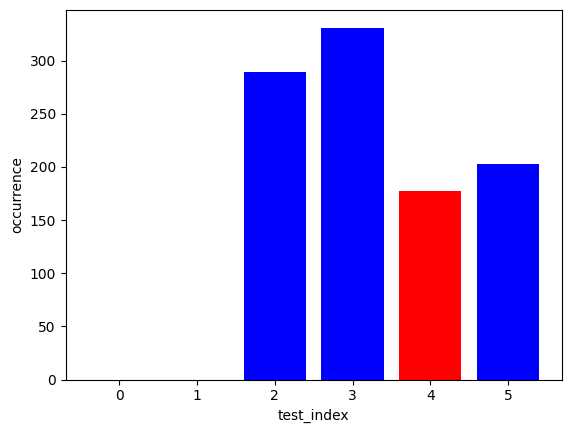

  0%|          | 0/1000 [00:00<?, ?it/s]

array([[0.07835559, 0.07835925, 0.21289751, 0.20999392, 0.20743762,
        0.21295612]])

array([  0.,   0., 293., 331., 168., 208.])

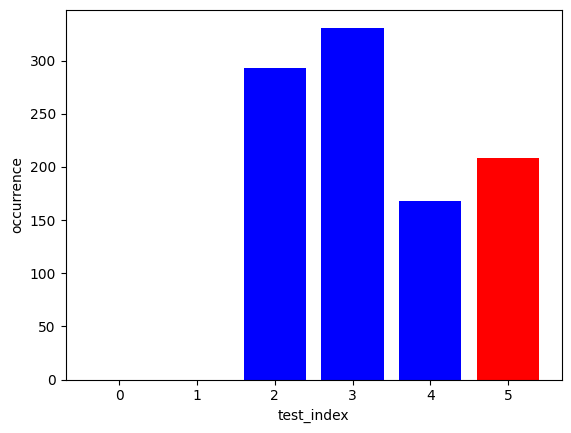

In [14]:
num_validation = 1000
test_cases = ["human-1", "human-2", "man-1", "woman-1", "woman-2", "woman-3"]

with torch.no_grad():
  for test_index in range(len(dataset.voices)):
    colors = ["b" if i != test_index else "r" for i in range(len(dataset.voices))]
    avg = np.zeros((1, len(dataset.voices)))
    occurrences = np.zeros(len(dataset.voices))
    for i in tqdm(range(num_validation)):
      t = load_voice(f"./data/bark3/{test_cases[test_index]}.wav")
      samples, targets = dataset.get_selected(t)
      outputs = model(samples.to(device).unsqueeze(0), targets.to(device).unsqueeze(0))
      avg += outputs.cpu().numpy()
      occurrences[outputs.cpu().numpy().argmax()] += 1
    display(avg / num_validation)
    display(occurrences)
    plt.bar(np.arange(len(dataset.voices)), occurrences, color=colors)
    plt.xticks(range(len(dataset.voices)))
    plt.xlabel("test_index")
    plt.ylabel("occurrence")
    plt.show()
  # display(Audio(samples[0], rate=SAMPLE_RATE))
  # display(Audio(targets[0], rate=SAMPLE_RATE))
  # display(Audio(samples[1], rate=SAMPLE_RATE))
  # display(Audio(targets[1], rate=SAMPLE_RATE))
  # display(Audio(samples[2], rate=SAMPLE_RATE))
  # display(Audio(targets[2], rate=SAMPLE_RATE))

In [ ]:
preload_models(use_smaller_models=True)

In [ ]:
def generate(basename, raw_prompt, index):
  basepath = "./data/bark/"
  text_prompt = re.sub(r"\s\s+", " ", re.sub(r"[\t\n]", "", raw_prompt)).strip()
  print(f"{basename}: prompt-{index}")
  audio_array, generation_data = generate_audio(text_prompt, basename)
  if basename not in os.listdir(basepath): os.mkdir(f"{basepath}/{basename}")
  save_history(f"{basepath}/{basename}/prompt-{index}", audio_array, text_prompt, generation_data)

In [ ]:
with open("./prompts.json") as fp: raw_prompts = json.load(fp)
len(raw_prompts)

100

In [ ]:
prompt = "Bark was developed for research purposes. It is not a conventional text-to-speech model but instead a fully generative text-to-audio model, which can deviate in unexpected ways from provided prompts."
audio_array, generation_data = generate_audio(prompt)
Audio(audio_array, rate=SAMPLE_RATE)

history_prompt in gen: None


100%|██████████| 32/32 [00:28<00:00,  1.11it/s]


In [ ]:
save_history("./data/bark/woman-4", audio_array, prompt, generation_data)